In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf

import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

print("All packages are imported successfully")

All packages are imported successfully


In [3]:
print("Preparing workspace")
root_path = './btc_ohlc_Oct_2015_to_Oct_2021.csv'
btc_input_df = pd.read_csv(root_path)

# Changing time column to datetime64
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64[ns]'})
#btc_input_df_datetype.info()



Preparing workspace


In [1]:
"""
Plotting to visualize dataset
"""
btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")


plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=43200) #month lag
plt.title('1-Month Lag')

#plt.legend()
plt.show()

NameError: name 'btc_input_df_datetype' is not defined

In [4]:
"""
1. adding "date" column to the dataset
2. sorting the dataset according to a date
3. getting mean of a day with closed value

btc_closing_price_groupby_date contains a mean of a closing value for a day
"""
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close'].mean()

In [5]:
"""
Preparing training
"""
prediction_days = 60

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

print("df_test:", df_test.shape , " df_train:" , df_train.shape)

df_test: (60, 1)  df_train: (2136, 1)


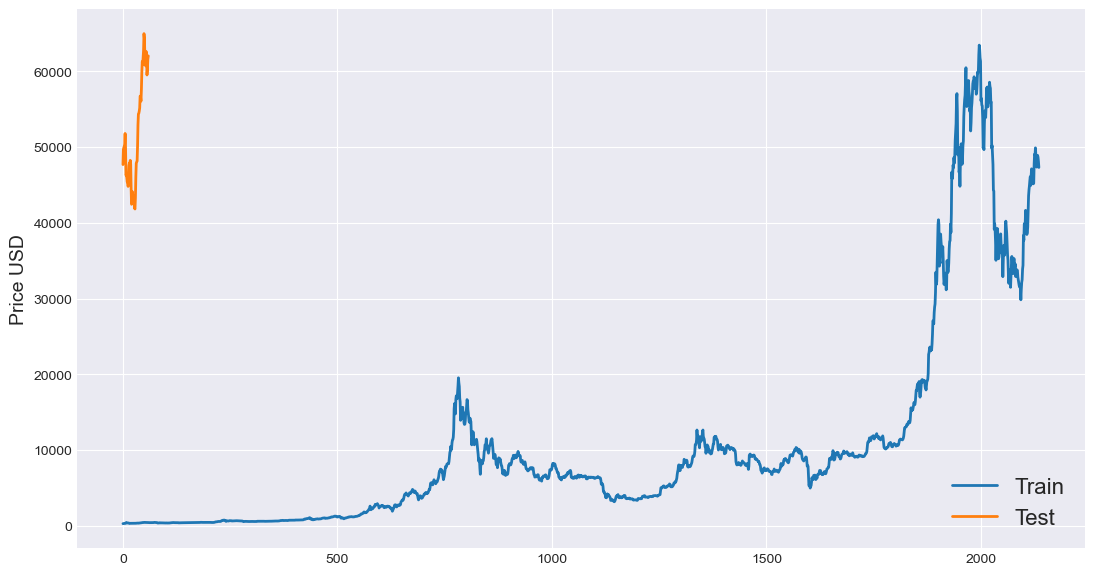

In [22]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)


In [6]:
"""
Scaling must be done after the data has been split 
into training and test sets — with each being scaled separately.

A common mistake when using the LSTM is to first 
normalize the data before splitting the data.

The reason this is erroneous is that the normalization technique 
will use data from the test sets as a reference point when scaling 
the data as a whole. This will inadvertently influence the values of the 
training data, essentially resulting in data leakage from the test sets.
"""

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)


In [15]:
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)


trainX:  (2131, 5)
trainY:  (2131,)
testX:  (55, 5)
testY (55,)


In [161]:
"""
1. What is Sequential class
   - it is a list in which we can stack our layers of training model
2. What is units in lstm
   - seems lie it is Number of hidden cells (longterm memory)
3. How does Dropout works and helps
   - 
4. What else can LSTM provide us helpful
"""

regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Note - If I plan to add 3-rd or 4-th layers of LSTM then 
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 5, 128)            66560     
                                                                 
 dropout_20 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [162]:
"""
So to emphasize the input to every LSTM layer must be three-dimensional.
The three dimensions of this input are:

Samples. One sequence is one sample. 
A batch is comprised of one or more samples.

Time Steps. One time step is one point of observation in the sample.

Features. One feature is one observation at a time step.

"""
print(trainX[:5])
print(trainX.shape)
print("reshaping")
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

print(trainX[:5])


testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)


[[[0.        ]
  [0.00014416]
  [0.00027947]
  [0.00053485]
  [0.0004907 ]]

 [[0.00014416]
  [0.00027947]
  [0.00053485]
  [0.0004907 ]
  [0.00042182]]

 [[0.00027947]
  [0.00053485]
  [0.0004907 ]
  [0.00042182]
  [0.00073375]]

 [[0.00053485]
  [0.0004907 ]
  [0.00042182]
  [0.00073375]
  [0.00148661]]

 [[0.0004907 ]
  [0.00042182]
  [0.00073375]
  [0.00148661]
  [0.0024883 ]]]
(2131, 5, 1)
reshaping
[[[0.        ]
  [0.00014416]
  [0.00027947]
  [0.00053485]
  [0.0004907 ]]

 [[0.00014416]
  [0.00027947]
  [0.00053485]
  [0.0004907 ]
  [0.00042182]]

 [[0.00027947]
  [0.00053485]
  [0.0004907 ]
  [0.00042182]
  [0.00073375]]

 [[0.00053485]
  [0.0004907 ]
  [0.00042182]
  [0.00073375]
  [0.00148661]]

 [[0.0004907 ]
  [0.00042182]
  [0.00073375]
  [0.00148661]
  [0.0024883 ]]]
Shape of trainX:  (2131, 5, 1)
Shape of testX:  (55, 5, 1)


In [163]:
"""
1. How well will others optimizers perform?
2. What is loss
3. What is checkpoint
   - Checkpint is used to save result before applyting test data
4. what is validation_Data in fit
5. which parameters fit has
"""
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
# callbacks = [checkpoint]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 12, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)


Epoch 1/12
67/67 [==============================] - ETA: 0s - loss: 0.0177
Epoch 1: val_loss improved from inf to 0.05938, saving model to my_best_model.hdf5
67/67 [==============================] - 4s 43ms/step - loss: 0.0177 - val_loss: 0.0594
Epoch 2/12
67/67 [==============================] - ETA: 0s - loss: 0.0258
Epoch 2: val_loss improved from 0.05938 to 0.01516, saving model to my_best_model.hdf5
67/67 [==============================] - 2s 35ms/step - loss: 0.0258 - val_loss: 0.0152
Epoch 3/12
67/67 [==============================] - ETA: 0s - loss: 0.0028
Epoch 3: val_loss improved from 0.01516 to 0.01443, saving model to my_best_model.hdf5
67/67 [==============================] - 2s 35ms/step - loss: 0.0028 - val_loss: 0.0144
Epoch 4/12
67/67 [==============================] - ETA: 0s - loss: 0.0017
Epoch 4: val_loss did not improve from 0.01443
67/67 [==============================] - 2s 34ms/step - loss: 0.0017 - val_loss: 0.0154
Epoch 5/12
67/67 [==========================

In [164]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)


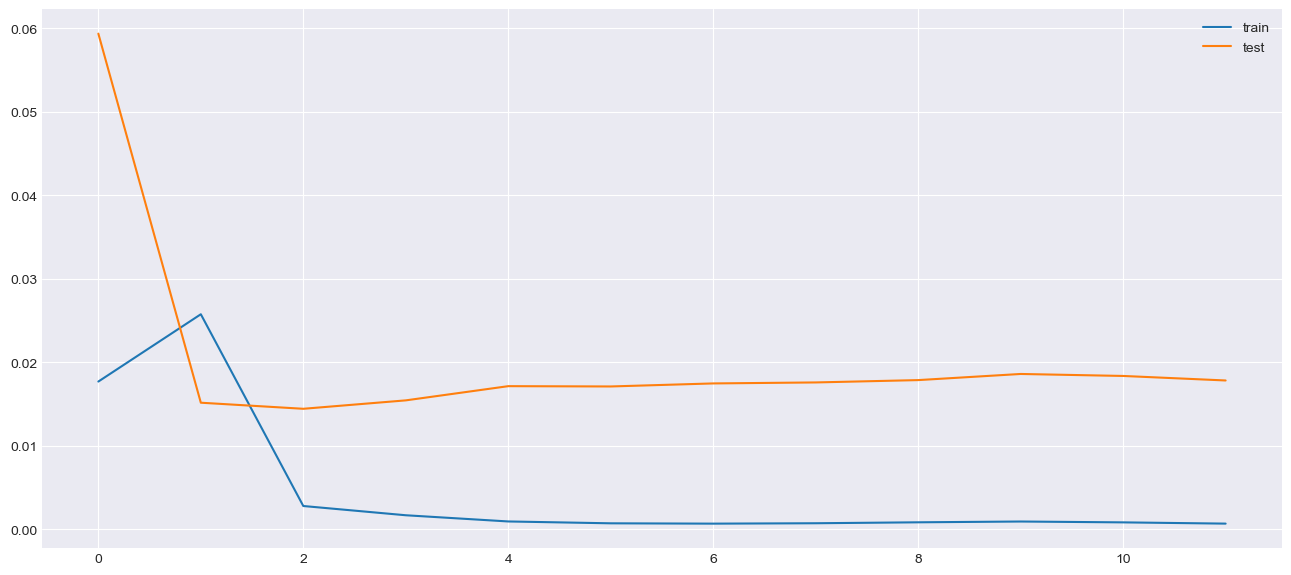

In [165]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [166]:
"""
Why do we inverse_transfrom
"""
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))


2/2 [==============================] - 0s 34ms/step


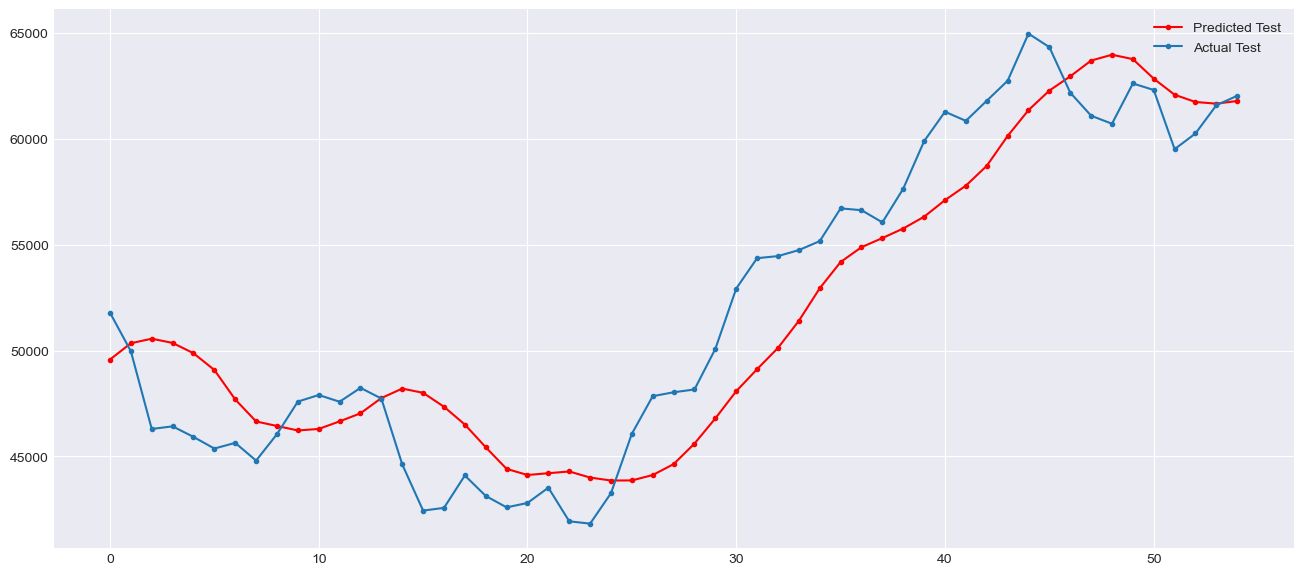

In [167]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()


In [168]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))


67/67 [==============================] - 1s 7ms/step


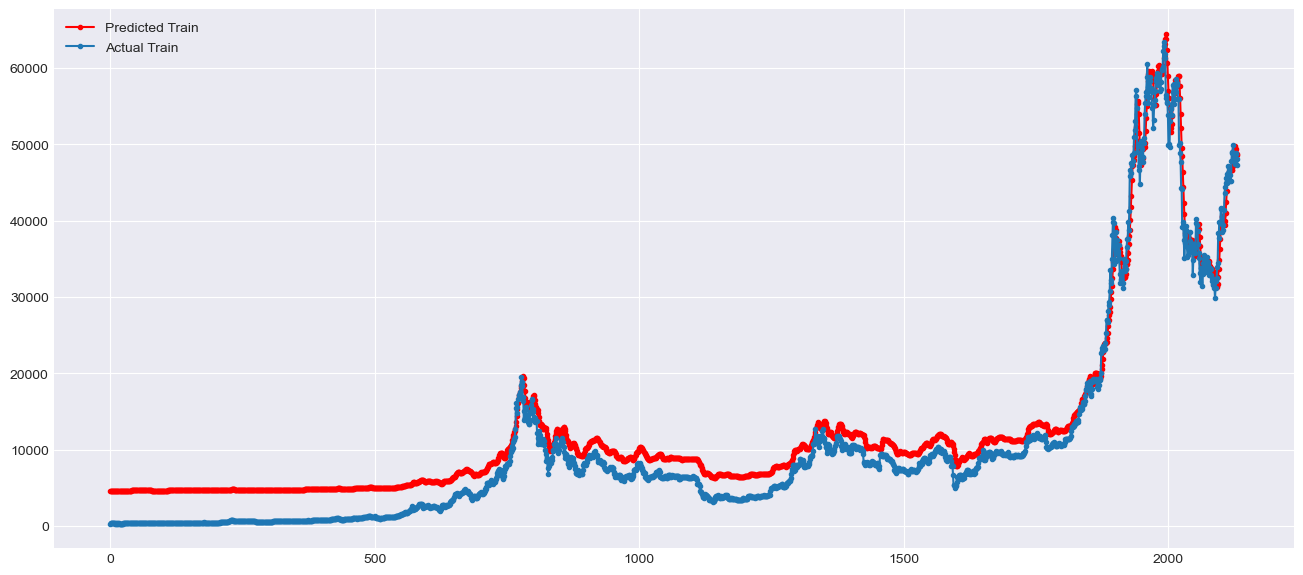

In [169]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()


In [170]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best


Test RMSE: 2779.433


In [171]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1047.916  => This seems best


Test RMSE: 2999.386


In [56]:
"""
PREDICTING FUTURE
"""

'\nPREDICTING FUTURE\n'

In [172]:
lookback_period = 5

# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast for Future 5 days beyond 30-Oct-2021

testX_last_5_days = testX[testX.shape[0] - lookback_period :  ]

testX_last_5_days.shape


(5, 5, 1)

In [173]:
predicted_5_days_forecast_price_test_x = []

for i in range(5):  
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])
  
  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)
  
print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x)) 
# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast beyond 30-Oct-2021


1/1 [==============================] - 0s 15ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[62837.203]]

 [[62078.066]]

 [[61736.574]]

 [[61657.402]]

 [[61784.445]]]


In [174]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)


In [175]:
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()

predicted_5_days_forecast_price_test_x


array([62837.203, 62078.066, 61736.574, 61657.402, 61784.445],
      dtype=float32)

In [176]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

predicted_btc_price_test_data


array([49572.805, 50343.484, 50558.82 , 50359.234, 49872.4  , 49082.02 ,
       47689.656, 46651.035, 46436.637, 46224.953, 46297.027, 46654.312,
       47034.652, 47754.797, 48203.137, 48002.684, 47344.54 , 46504.754,
       45432.547, 44410.56 , 44122.082, 44205.82 , 44288.395, 44001.457,
       43861.297, 43865.043, 44120.3  , 44634.695, 45605.73 , 46796.33 ,
       48079.17 , 49119.93 , 50122.59 , 51404.113, 52938.953, 54180.137,
       54879.58 , 55310.59 , 55762.008, 56318.312, 57101.383, 57785.11 ,
       58720.402, 60129.895, 61352.383, 62275.61 , 62947.824, 63692.816,
       63968.094, 63761.32 , 62837.2  , 62078.066, 61736.574, 61657.402,
       61784.445], dtype=float32)

In [177]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_5_days_forecast_price_test_x))

predicted_btc_test_concatenated

predicted_btc_test_concatenated.shape


(60,)

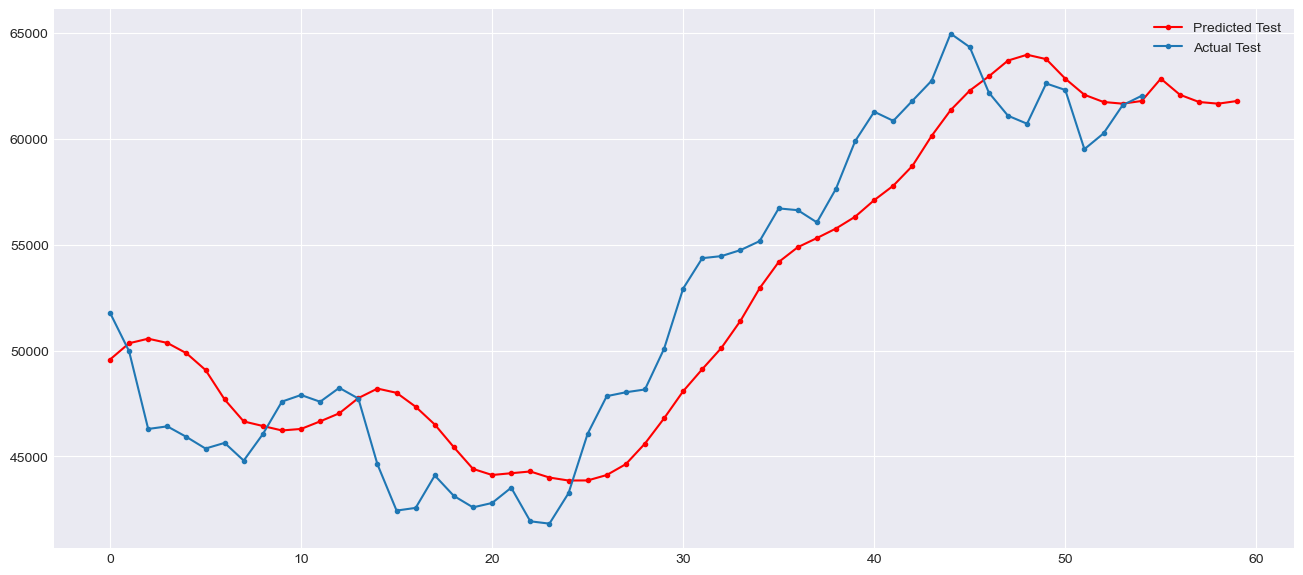

In [178]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()
